## The Trade-wind Cumulus Model

### Python packages

In [20]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import colormaps as cmaps

### Functions

In [21]:
# Latent heat of vaporization of water as a function of temperature [K]
def Lv(T):
    """
    Environmental Laboratory (1986). CE-QUAL-R1: A numerical one-dimensional model of rewervoir water quality. User's Manual,
    Instruction Report E-82-1 (Revised Edition), US Army Engineer Experiment Station, Vicksburg, Miss. pp.63-64.
    https://usace.contentdm.oclc.org/digital/collection/p266001coll1/id/6873/
    """
    Cpv = 1870   # Specific heat capacity of water vapor at constant pressure [J/kg/K] Bolton
    Cw  = 4190   # Specific heat capacity of liquid water at constant pressure [J/kg/K] Bolton
    T0  = 273.15 # Reference temperature [K]
    return 2.501e6 + (Cpv - Cw) * (T - T0) # [J/kg]

# Wexler/Buck 1981 formula (with enhancement factor at standard pressure)
def es_wexler(T_C, P=1013.25):  # P in hPa; T_C in Celsius
    """
    Buck, A. L. (1981). New Equations for Computing Vapor Pressure and Enhancement Factor. J. Appl. Meteorol., 20(12), 1527–1532.
    https://doi.org/10.1175/1520-0450(1981)020%3C1527:NEFCVP%3E2.0.CO;2
    """
    return 1e2 * 6.1121 * (1.0007 + 3.46e-6 * P) * np.exp((17.502 * T_C) / (240.97 + T_C))

# Saturation vapor pressure calculations
def q_sat(T_C, p=101325):  # p in Pa (default = 1013.25 hPa)
    Rv  = 461.5  # Gas constant for water vapor [J/kg/K]
    Rd  = 287.04 # Gas constant for dry air [J/kg/K]
    epsilon = Rd / Rv  # ratio of gas constants
    # es  = es_clausius_clapeyron(T_C)
    # es  = es_tetens(T_C)
    es  = es_wexler(T_C)
    return (epsilon * es) / (p - (1 - epsilon) * es)

# Total water content calculation
def q_total(ae, dz, x, qs, qm, q_zcb, izcb):
    qtilde = (1 - x) * qm + x * qs

    qt = qtilde.copy()
    qt[0:izcb+1] = q_zcb  # set sub-cloud specific humidity
                          # Python is start inclusive, end exclusive, so must use izcb+1
                          # So qt[0:izcb+1] includes qt[izcb]
    for iz in range(izcb, len(qt)-1):
        if qt[iz] > qs[iz]:
            a1 = ae * dz
            Q1 = (qtilde[iz+1] + qtilde[iz]) / 2
            qt[iz+1] = ( (1-a1/2) * qt[iz] + a1*Q1 ) / (1 + a1/2)
        else:
            a2 = (1 - x) * ae * dz
            Q2 = (qm[iz+1] + qm[iz]) / 2
            qt[iz+1] = ( (1-a2/2) * qt[iz] + a2*Q2 ) / (1 + a2/2)
    return qt

# Cloud water flux calculation
# def cloudflux(ae, dz, x, ql, qm, qs, Ft, izcb, Ecb, rho_L):
#     Q = x * ae * ql / (qs - qm) * dz
def cloudflux(ae, dz, x, ql, qm, qt, Ft, izcb, Ecb, rho_L):
    Q = x * ae * ql / (qt - qm) * dz
    Fcld = Ft.copy()
    Fcld[:] = np.nan
    Fcld[izcb] = Ecb / rho_L
    for iz in range(izcb, len(Fcld)-1):
        Fcld[iz+1] = (Ft[iz+1] - Ft[iz] + Fcld[iz] * (1 - Q[iz]/2)) / (1 + Q[iz+1]/2)
    return Fcld

# def cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct):
#     Q = x * ae * ql / (qs - qm) * dz
def cloudflux_downward(ae, dz, x, ql, qm, qt, Ft, izcb, izct):
    Q = x * ae * ql / (qt - qm) * dz
    Fcld = Ft.copy()
    Fcld[:izct] = np.nan
    for iz in range(izct, izcb-1, -1):
        Fcld[iz] = (Ft[iz] - Ft[iz+1] + Fcld[iz+1] * (1 + Q[iz+1]/2)) / (1 - Q[iz]/2)
    return Fcld

### Data
We obtain environmental mean profiles of specific humidity, temperature, and pressure from the Ronald Brown ship sounding data while preciptiation rate, surface air density and temperature are from the surface measurements (Quinn et al., 2021; https://doi.org/10.5194/essd-13-1759-2021).
- https://www.ncei.noaa.gov/archive/accession/ATOMIC-2020
- The Atlantic Tradewind Ocean-Atmosphere Mesoscale Interaction Campaign (ATOMIC) was a field campaign held January-February 2020 in the tropical North Atlantic east of Barbados. The campaign, the U.S. complement to the European field campaign called EUREC4A, was aimed at better understanding cloud and air-sea interaction processes. ATOMIC included in measurements from a NOAA WP-3D Orion "Hurricane Hunter" aircraft, the research ship Ronald H. Brown, and unpiloted vehicles launched from Barbados and from the Ronald H. Brown.

In [22]:
# Ronald Brown data
rdir = "/Users/huang/Data/SimonsCAT/ATOMIC/RonBrown"
dsr  = xr.open_dataset(Path(rdir, "RonBrown_radiosondes.nc"))
dss  = xr.open_dataset(Path(rdir, "RonBrown_10min_flux.nc"))

### Variables

In [23]:
# Variables from Ronald Brown data
# Mean profiles over soundings
z    = dsr['alt'].values       # shape (alt,) [m]
tam  = dsr['ta'].mean(dim='sounding', skipna=True).values # mean air temperature [K]
qm   = dsr['q'].mean(dim='sounding', skipna=True).values # mean specific humidity [kg/kg]
pm   = dsr['p'].mean(dim='sounding', skipna=True).values # mean air pressure [Pa]

# Mean fluxes over 10-min intervals
# lhf     = dss['hl_bulk'].values.squeeze()  # surface downward latent heat flux [W/m^2]
pr       = dss['prate'].values.squeeze()    # precipitation rate [mm/hr]
# ep      = dss['evap'].values.squeeze()    # evaporation rate [mm/hr]
rho_sfc  = dss['rhoair10'].values.squeeze()  # surface air density at 10-m [kg/m^3]
tair_sfc = dss['tair_ship'].values.squeeze()  # surface air temperature [degC]

In [24]:
# Constants
T0      = 273.15 # Reference temperature [K]
Rd      = 287.04 # Gas constant for dry air [J/kg/K]

zi      = 3000   # Inversion height [m]
ztop    = 4000   # Top of trade cumulus cloud layer [m]
divg    = 1e-6   # Divergence of vertical velocity [s^-1]
# rho_sfc = 1.16   # Surface density [kg/m^3] obtained from surface data instead

In [25]:
# Variables derived from mean profiles
qs   = q_sat(tam - T0, pm)  # saturation specific humidity
dz   = (z[1] - z[0])        # vertical grid spacing in m
# dqdz = np.gradient(qm, dz)  # vertical gradient of specific humidity (central difference)
dqdz = np.diff(qm) / dz     #                                        (forward difference)

# Latent heat of vaporization avg LOWER than ztop
# Lv_m  = Lv(np.nanmean(tam[z <= ztop])) # [2.47e+6 J/kg]
# rho   = np.nanmean(pm[z <= ztop]) / (Rd * np.nanmean(tam[z <= ztop])) # mean air density avg lower than ztop [kg/m^3]
# rho_L = rho * Lv_m # Latent heat of vaporization times density avg lower than ztop [kg/m^3 J/kg]

# Latent heat of vaporization at SURFACE
Lvsfc_m  = Lv(np.nanmean(tair_sfc) + T0) # [2.44e+6 J/kg]
rhosfc_m = np.nanmean(rho_sfc) # mean surface air density [kg/m^3]
rhosfc_L = rhosfc_m * Lvsfc_m # Latent heat of vaporization times surface density [kg/m^3 J/kg]

### Prescribed large-scale terms

In [26]:
# Calculations: large-scale advections (prescribed)
# Vertical velocity w(z) = -divg * z [m/s]
# Vertical moisture advection (subsidence drying: -w(z) * dq/dz)
w_dqdz = -( -divg * np.minimum(z[:-1], zi) ) * dqdz  # [1/s] # use z if dqdz is central difference

# Horizontal moisture advection (moisture convergence: ui * dq/dxi)
u_dqdx = -1.7e-8 * np.maximum(0, (ztop - z[:-1])/ztop)

ls_adv = w_dqdz + u_dqdx

In [27]:
# Perturbed large-scale advections (5% reduction)
w5_dqdz = -( -divg * np.minimum(z[:-1], zi) * 0.95 ) * dqdz

ls5_adv = w5_dqdz + u_dqdx

### The MODEL
- $\alpha+\epsilon$ varys from 5 to 0.649884 $km^{-1}$ (0.649884 is where we can have the highest cloud-top)
- FCloud-base height ($z_{cb}$) is chosen to be 700-m with specific humidify ($q_{zcb}$) equals 0.0152 $kg/kg$
- Precipitation efficiency ($x$) is ASSUMED to be a constant here ($x=0.56$, which is constrained by cloud-top height distribution).

In [28]:
# Pre-defined constants
Ecb = 170  # Evaporation rate at cloud base [W/m^2]
zcb = 700  # Cloud base height [m]
x   = 0.56 # Precipitation efficiency

# Total moisture flux at cloud base
Fcb = Ecb / rhosfc_L - np.nanmean(pr) / 3600 # [kg/kg m/s]
izcb = np.where(z >= zcb)[0][0]  # find index where height is greater than or equal to zcb
q_zcb = qs[izcb]  # specific humidity at cloud base height

# Integrate total moisture flux balancing subsidence drying and horizontal advection from cloud base
Ft = qm.copy()
Ft[1:izcb] = np.nan
ls_adv_cumsum = np.concatenate( ([0], np.cumsum(ls_adv[izcb:] * dz)) )
w_adv_cumsum = np.concatenate( ([0], np.cumsum(w_dqdz[izcb:] * dz)) )
Ft[izcb:] = Fcb + ls_adv_cumsum

# Total sinking rate (entrainment + autoconversion): ec + ac [1/km]
# 0.649884 is the minimum value that gives cloud-top below 4000 m (highest cloud-top height)
aeo = 1e-3 * np.array([6, 5, 4, 3, 2.5, 2, 1.5, 1, 0.649884])
ec = (1 - x) * aeo # entrainment coefficient
ac = x * aeo       # autoconversion coefficient

In [10]:
# Perturbed large-scale advections (5% reduction)
# Integrate total moisture flux balancing subsidence drying and horizontal advection from cloud base
Ft5 = qm.copy()
Ft5[1:izcb] = np.nan
ls5_adv_cumsum = np.concatenate( ([0], np.cumsum(ls5_adv[izcb:] * dz)) )
w5_adv_cumsum = np.concatenate( ([0], np.cumsum(w5_dqdz[izcb:] * dz)) )
Ft5[izcb:] = Fcb + ls5_adv_cumsum

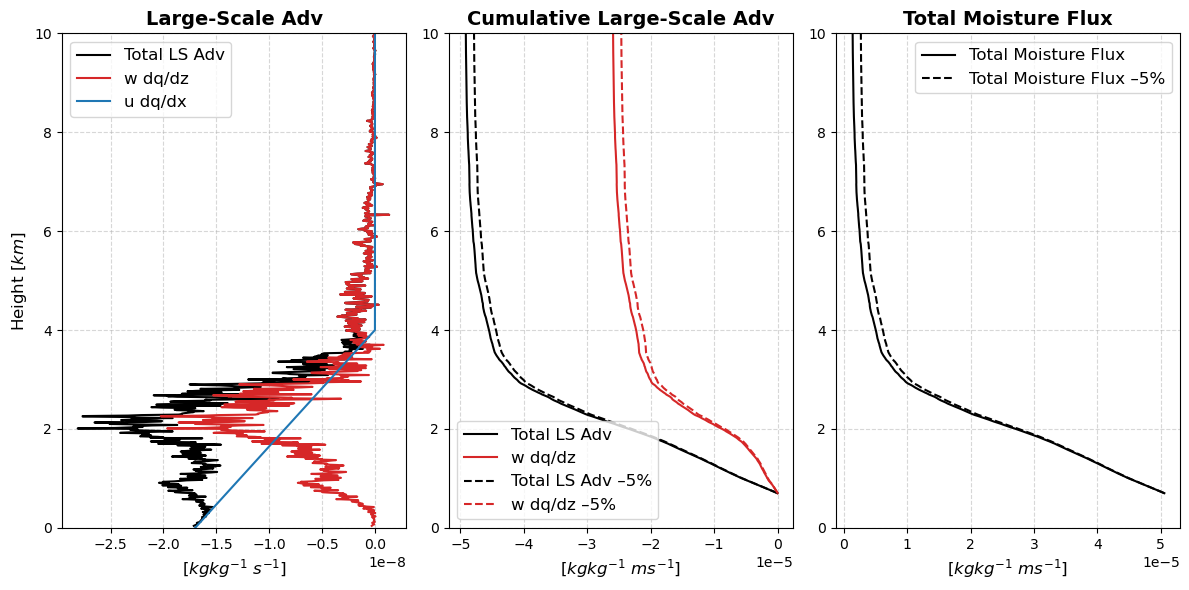

In [29]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(ls_adv, z[:-1]/1e3, color='k', label='Total LS Adv')
plt.plot(w_dqdz, z[:-1]/1e3, color='tab:red', label='w dq/dz')
plt.plot(u_dqdx, z[:-1]/1e3, color='tab:blue', label='u dq/dx')

plt.ylim(0, 10)

plt.xlabel(f'[$kgkg^{{-1}}$ $s^{{-1}}$]', fontsize=12)
plt.ylabel(f'Height [$km$]', fontsize=12)
plt.title('Large-Scale Adv', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)

plt.grid(linestyle='--', alpha=0.5)

plt.subplot(1, 3, 2)
plt.plot(ls_adv_cumsum, z[izcb:]/1e3, color='k', label='Total LS Adv')
plt.plot(w_adv_cumsum, z[izcb:]/1e3, color='tab:red', label='w dq/dz')
plt.plot(ls5_adv_cumsum, z[izcb:]/1e3, color='k', linestyle='--', label='Total LS Adv –5%')
plt.plot(w5_adv_cumsum, z[izcb:]/1e3, color='tab:red', linestyle='--', label='w dq/dz –5%')

plt.ylim(0, 10)

plt.xlabel(f'[$kgkg^{{-1}}$ $ms^{{-1}}$]', fontsize=12)
plt.title('Cumulative Large-Scale Adv', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='lower left')

plt.grid(linestyle='--', alpha=0.5)

plt.subplot(1, 3, 3)
plt.plot(Ft, z/1e3, color='k', label='Total Moisture Flux')
plt.plot(Ft5, z/1e3, color='k', linestyle='--', label='Total Moisture Flux –5%')

plt.ylim(0, 10)

plt.xlabel(f'[$kgkg^{{-1}}$ $ms^{{-1}}$]', fontsize=12)
plt.title('Total Moisture Flux', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')

plt.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [31]:
# Run model for multiple combinations of α+ϵ
qt_out = []
ql_out = []
Fcld_out = []
Fpr_out = []
W_out = []
for ae in aeo:
    # === Fixed precipitation efficiency x ===
    # Calculate total water content
    qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
    ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

    # Find the cloud-top height where ql goes to zero above the cloud base
    izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb
    print(f"Case with α+ϵ= {ae*1e+3:.6f} 1/km, cloud top at {z[izct]:.2f} m")

    # Calculate cloud moisture flux (integrating downward from cloud top)
    # Fcld = cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct)
    Fcld = cloudflux_downward(ae, dz, x, ql, qm, qt, Ft, izcb, izct)
    Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top

    # Calculate mass flux
    # W = Fcld / (qs - qm)
    W = Fcld / (qt - qm)

    # Output results
    qt_out.append(qt)
    ql_out.append(ql)
    Fcld_out.append(Fcld)
    Fpr_out.append(Fpr)
    W_out.append(W)


Case with α+ϵ= 6.000000 1/km, cloud top at 700.00 m
Case with α+ϵ= 5.000000 1/km, cloud top at 850.00 m
Case with α+ϵ= 4.000000 1/km, cloud top at 1000.00 m
Case with α+ϵ= 3.000000 1/km, cloud top at 1440.00 m
Case with α+ϵ= 2.500000 1/km, cloud top at 1630.00 m
Case with α+ϵ= 2.000000 1/km, cloud top at 1830.00 m
Case with α+ϵ= 1.500000 1/km, cloud top at 2000.00 m
Case with α+ϵ= 1.000000 1/km, cloud top at 2280.00 m
Case with α+ϵ= 0.649884 1/km, cloud top at 3400.00 m


In [32]:
# Perturbed large-scale advections (5% reduction)
# Run model for multiple combinations of α+ϵ
qt5_out = []
ql5_out = []
Fcld5_out = []
Fpr5_out = []
W5_out = []
for ae in aeo:
    # === Fixed precipitation efficiency x ===
    # Calculate total water content
    qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
    ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

    # Find the cloud-top height where ql goes to zero above the cloud base
    izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb
    print(f"Case with α+ϵ= {ae*1e+3:.6f} 1/km, cloud top at {z[izct]:.2f} m")

    # Calculate cloud moisture flux (integrating downward from cloud top)
    # Fcld = cloudflux_downward(ae, dz, x, ql, qm, qs, Ft5, izcb, izct)
    Fcld = cloudflux_downward(ae, dz, x, ql, qm, qt, Ft5, izcb, izct)
    Fpr = Fcld - Ft5 # Precipitation flux must be zero above cloud top

    # Calculate mass flux
    # W = Fcld / (qs - qm)
    W = Fcld / (qt - qm)

    # Output results
    qt5_out.append(qt)
    ql5_out.append(ql)
    Fcld5_out.append(Fcld)
    Fpr5_out.append(Fpr)
    W5_out.append(W)


Case with α+ϵ= 6.000000 1/km, cloud top at 700.00 m
Case with α+ϵ= 5.000000 1/km, cloud top at 850.00 m
Case with α+ϵ= 4.000000 1/km, cloud top at 1000.00 m
Case with α+ϵ= 3.000000 1/km, cloud top at 1440.00 m
Case with α+ϵ= 2.500000 1/km, cloud top at 1630.00 m
Case with α+ϵ= 2.000000 1/km, cloud top at 1830.00 m
Case with α+ϵ= 1.500000 1/km, cloud top at 2000.00 m
Case with α+ϵ= 1.000000 1/km, cloud top at 2280.00 m
Case with α+ϵ= 0.649884 1/km, cloud top at 3400.00 m


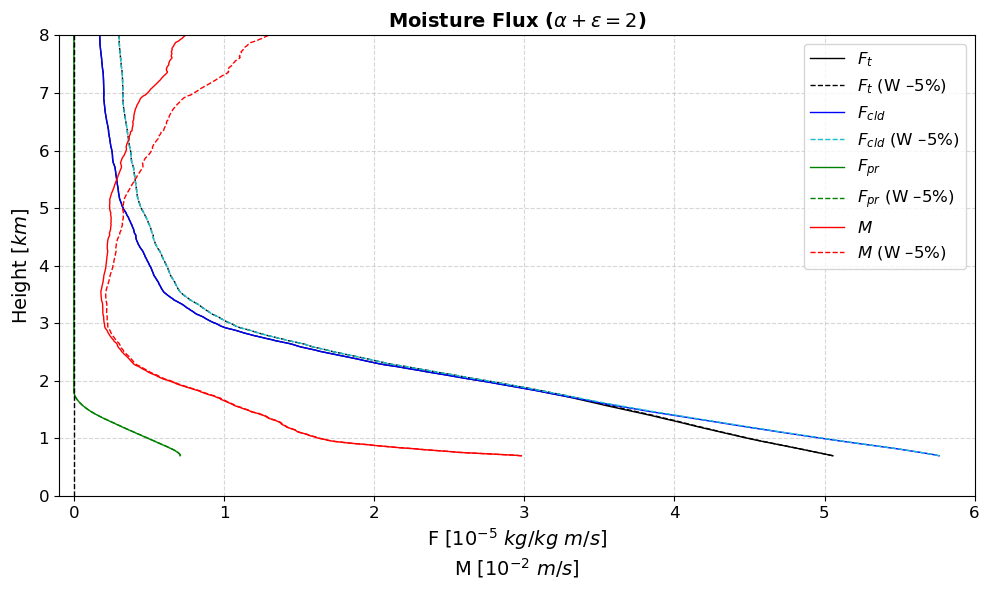

In [33]:
plt.figure(figsize=(10, 6))

plt.plot(Ft*1e+5, z/1e3, color='k', linewidth=1, label='$F_t$')
plt.plot(Ft5*1e+5, z/1e3, color='k', linestyle='--', linewidth=1, label='$F_t$ (W –5%)')

# Case with α+ϵ= 2 1/km
iae = np.where(aeo == 2e-3)[0][0]
plt.plot(Fcld_out[iae]*1e+5, z/1e3, color='b', linewidth=1, label='$F_{cld}$')
plt.plot(Fcld5_out[iae]*1e+5, z/1e3, color='tab:cyan', linestyle='--', linewidth=1, label='$F_{cld}$ (W –5%)')

plt.plot(Fpr_out[iae]*1e+5, z/1e3, color='g', linewidth=1, label='$F_{pr}$')
plt.plot(Fpr5_out[iae]*1e+5, z/1e3, color='g', linestyle='--', linewidth=1, label='$F_{pr}$ (W –5%)')

plt.plot(W_out[iae]*1e+2, z/1e3, color='r', linewidth=1, label='$M$')
plt.plot(W5_out[iae]*1e+2, z/1e3, color='r', linestyle='--', linewidth=1, label='$M$ (W –5%)')

plt.axvline(0, color='k', linestyle='--', linewidth=1)

plt.xlim(-0.1, 6)
plt.ylim(0, 8)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel(r'F [$10^{-5}$ $kg/kg$ $m/s$]' '\n' 'M [$10^{-2}$ $m/s$]', fontsize=14)
plt.ylabel(f'Height [$km$]', fontsize=14)
plt.title(r'Moisture Flux ($\alpha+\epsilon=2$)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')

plt.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Plot

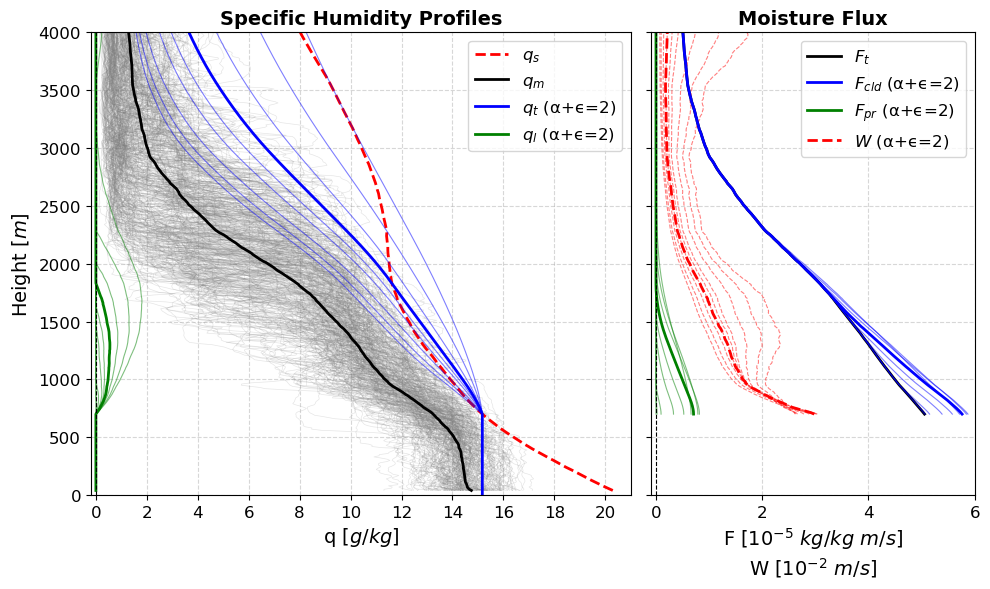

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [5, 3]})

# Observations from Ron Brown soundings
for i in range(dsr['sounding'].size):
    ax1.plot(dsr['q'].isel(sounding=i).values*1000, z, color='gray', linewidth=0.5, alpha=0.2)
ax1.plot(qs*1000, z, color='r', linestyle='--', linewidth=2, label='$q_s$')
ax1.plot(qm*1000, z, color='k', linewidth=2, label='$q_m$')

ax2.plot(Ft*1e+5, z, color='k', linewidth=2, label='$F_t$')

for iae in range(len(aeo)):
    ax1.plot(qt_out[iae]*1000, z, color='b', linewidth=0.8, alpha=0.5)
    ax1.plot(ql_out[iae]*1000, z, color='g', linewidth=0.8, alpha=0.5)

    ax2.plot(Fcld_out[iae]*1e+5, z, color='b', linewidth=0.8, alpha=0.5)
    ax2.plot(Fpr_out[iae]*1e+5, z, color='g', linewidth=0.8, alpha=0.5)
    ax2.plot(W_out[iae]*1e+2, z, linestyle='--', color='r', linewidth=0.8, alpha=0.5)

    ax1.set_xlim(-0.2, 21)
    ax1.set_ylim(0, 4000)
    xticks = np.arange(0, 21, 2)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.set_xlabel(f'q [$g/kg$]', fontsize=14)
    ax1.set_ylabel(f'Height [$m$]', fontsize=14)
    ax1.set_title('Specific Humidity Profiles', fontsize=14, fontweight='bold')
    ax1.grid(linestyle='--', alpha=0.5)

    ax2.set_xlim(-0.1, 6)
    ax2.set_ylim(0, 4000)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.set_xlabel(r'F [$10^{-5}$ $kg/kg$ $m/s$]' '\n' 'W [$10^{-2}$ $m/s$]', fontsize=14)
    ax2.set_yticklabels([])  # Hide y-axis labels on the right plot
    ax2.set_title('Moisture Flux', fontsize=14, fontweight='bold')
    ax2.grid(linestyle='--', alpha=0.5)

# Case with α+ϵ= 2 1/km
iae = np.where(aeo == 2e-3)[0][0]
ax1.plot(qt_out[iae]*1000, z, color='b', linewidth=2, label='$q_t$ (α+ϵ=2)')
ax1.plot(ql_out[iae]*1000, z, color='g', linewidth=2, label='$q_l$ (α+ϵ=2)')
ax2.plot(Fcld_out[iae]*1e+5, z, color='b', linewidth=2, label='$F_{cld}$ (α+ϵ=2)')
ax2.plot(Fpr_out[iae]*1e+5, z, color='g', linewidth=2, label='$F_{pr}$ (α+ϵ=2)')
ax2.plot(W_out[iae]*1e+2, z, linestyle='--', color='r', linewidth=2, label='$W$ (α+ϵ=2)')

# Final touches
ax1.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax2.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax1.legend(fontsize=12, loc='upper right')
ax2.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()